In [6]:
import vcdvcd
import matplotlib.pyplot as plt
import numpy as np
from dataclasses import dataclass

In [7]:
def condition_signal_tv(tv):
    x, y = list(zip(*tv))
    if not isinstance(y[0], int):
        make_bin_to_int = lambda x : int(x, base=2)
        #x = map(make_bin_to_int, x)
        y = list(map(make_bin_to_int, y))
    tv = list(zip(x, y))
    return tv

def expand_signal(xin, yin, length=None):
    import numpy as np
    import pandas as pd
    xin = list(xin)
    if not length:
        length = max(xin)+1

    # Select all points less than length, then add last point, extrapolting that the last point has no transitions
    # This will always result in an accurate frame of the desired length
    df = pd.DataFrame({"x": xin, "y": yin})
    df = df[df["x"] < length]
    df.loc[len(df)] = {'x': length-1, "y": list(df["y"])[-1]}

    # At the transition add a double x point at the initial value before the change index
    dout = {"x": [], "y": []}
    for thisr, nextr in zip(df.iterrows(), list(df.iterrows())[1:]):
        _, next = nextr
        _, this = thisr
        dout["x"].append(this["x"])
        dout["y"].append(this["y"])

        dout["x"].append(next["x"])
        dout["y"].append(this["y"])
    return dout['x'], dout['y']

def condition_expand(signal, endtime: float):
    """Condition and expand VCD signal to endtime."""
    signal.tv = condition_signal_tv(signal.tv)
    x, y = list(zip(*signal.tv))
    x, y = expand_signal(x, y, endtime)
    return np.array(x, dtype=float), np.array(y, dtype=float)
    
@dataclass
class Signal:
    title: str
    x: np.array
    y: np.array
    xscale: float
    endtime: float

    @classmethod
    def load(cls, vcd: vcdvcd.VCDVCD, signal_id: str, title: str, endtime: float):
        xscale = float(vcd.timescale["timescale"])
        x, y = condition_expand(vcd[signal_id], endtime)
        return cls(title=title, x=np.asarray(x), y=np.asarray(y), xscale=xscale, endtime=endtime)

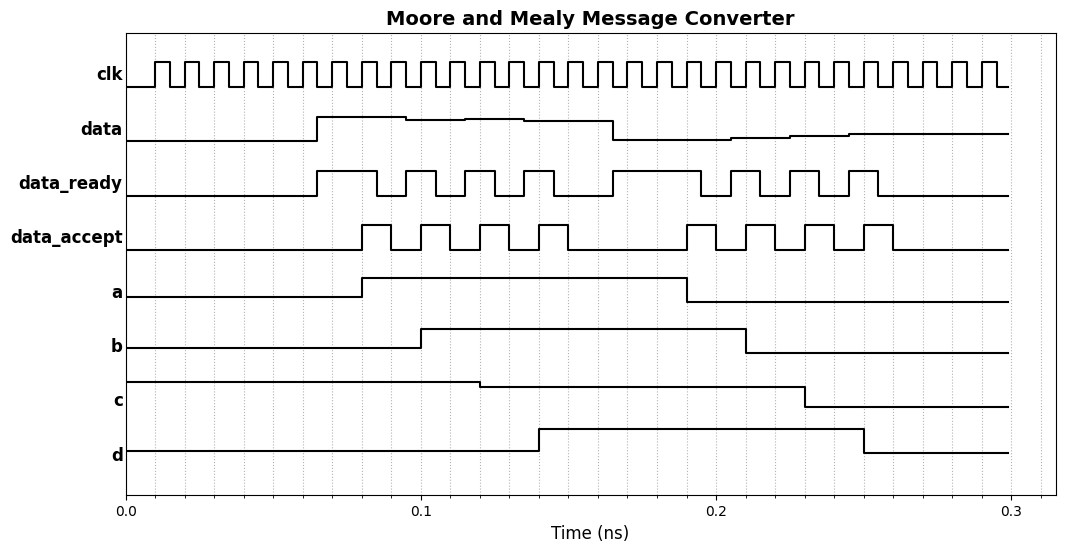

In [11]:
def get_signals(fname="../hdl/q2/logs/tb_in_wrapper.vcd"):
    vcd = vcdvcd.VCDVCD(fname)
    signal_tags = (
        ("TOP.clk", "clk"),
        ("TOP.data[15:0]", "data"),
        ("TOP.data_ready", "data_ready"),
        ("TOP.data_accept", "data_accept"),
        ("TOP.a[15:0]", "a"),
        ("TOP.b[15:0]", "b"),
        ("TOP.c[15:0]", "c"),
        ("TOP.d[15:0]", "d"),
    )
    
    endtime = max(vcd[name].endtime for name, _ in signal_tags)

    signals: List[Signal] = [
        Signal.load(vcd=vcd, signal_id=signal_id, title=title, endtime=endtime) 
        for signal_id, title in signal_tags]
    return signals

def plot_timing_diagram(signals):
    '''
    Normalize signals and space them out on one axis.
    '''
    fig, ax = plt.subplots(figsize=(12, 6))
    spacing = 2.2

    clk_signal = next(sig for sig in signals if sig.title == "clk")

    offsets = {}
    # Digital signals
    for i, signal in enumerate(signals):
        y_offset = -i * spacing
        offsets[signal.title] = y_offset  # store offset for later reference

        endtime = signal.endtime
        xscale = signal.xscale
        x = signal.x*xscale*1e9
        
        y_range = (max(signal.y)-min(signal.y))
        y = np.zeros_like(signal.y) if y_range == 0 else signal.y/y_range
    
        label = signal.title

        # Normalize: each digital waveform ranges from baseline (y_offset) to y_offset+1
        ax.step(x, y_offset + y, where="post", color="black", lw=1.5)
        ax.hlines(y_offset, 0, endtime * xscale, color="0.8",
                  lw=0.5, linestyle="--")  # baseline
        ax.text(-1e-3, y_offset + 0.5, label, ha="right", va="center",
                fontsize=12, weight="bold")

    clk_x = clk_signal.x * clk_signal.xscale * 1e9
    clk_y = clk_signal.y

    # Formatting
    ax.set_ylim(-spacing*(len(signals)-1) - spacing/2, spacing)
    ax.set_xlabel("Time (ns)", fontsize=12)
    ax.set_yticks([])
    ax.set_title("Moore and Mealy Message Converter", fontsize=14, weight="bold")

    # Gridlines
    ax.xaxis.set_major_locator(plt.MultipleLocator(0.10))
    ax.xaxis.set_minor_locator(plt.MultipleLocator(0.01))
    ax.grid(axis="x", which="minor", linestyle=":", color="0.7")
    ax.grid(axis="x", which="major", linestyle=":", color="0.7")

    return fig, [ax]
    
signals = get_signals()
fig, axes = plot_timing_diagram(list(signals))
axes[0].set_xlim(0, 0.315)
# fig.savefig("../report/assets/q2_wave.pdf", bbox_inches="tight")
plt.show()


In [ ]:
def get_signals(fname="../hdl/q3/logs/vlt_dump.vcd"):
    vcd = vcdvcd.VCDVCD(fname)
    signal_tags = (
        ("TOP.clk", "clk"),
        ("TOP.rstn", "rstn"),
        ("TOP.serdata", "serdata"),
        ("TOP.valid", "valid")
    )
    
    endtime = max(vcd[name].endtime for name, _ in signal_tags)

    signals: List[Signal] = [
        Signal.load(vcd=vcd, signal_id=signal_id, title=title, endtime=endtime) 
        for signal_id, title in signal_tags]
    return signals

def plot_timing_diagram(signals):
    '''
    Normalize signals and space them out on one axis.
    '''
    fig, ax = plt.subplots(figsize=(12, 6))
    spacing = 2.2

    clk_signal = next(sig for sig in signals if sig.title == "clk")
    valid_signal = next(sig for sig in signals if sig.title == "valid")

    offsets = {}
    # Digital signals
    for i, signal in enumerate(signals):
        y_offset = -i * spacing
        offsets[signal.title] = y_offset  # store offset for later reference

        endtime = signal.endtime
        xscale = signal.xscale
        x = signal.x*xscale*1e9
        
        y_range = (max(signal.y)-min(signal.y))
        y = np.zeros_like(signal.y) if y_range == 0 else signal.y/y_range
    
        label = signal.title

        # Normalize: each digital waveform ranges from baseline (y_offset) to y_offset+1
        ax.step(x, y_offset + y, where="post", color="black", lw=1.5)
        ax.hlines(y_offset, 0, endtime * xscale, color="0.8",
                  lw=0.5, linestyle="--")  # baseline
        ax.text(-1e-3, y_offset + 0.5, label, ha="right", va="center",
                fontsize=12, weight="bold")

    clk_x = clk_signal.x * clk_signal.xscale * 1e9
    clk_y = clk_signal.y
    valid_x = valid_signal.x * valid_signal.xscale * 1e9
    valid_y = valid_signal.y

    for i in range(len(valid_x) - 1):
        if valid_y[i] == 1:
            x0, x1 = valid_x[i], valid_x[i+1]
            ax.axvspan(x0, x1, ymin=0.110, ymax=0.210,
                       facecolor="lightblue", alpha=0.8)

    # Formatting
    ax.set_ylim(-spacing*(len(signals)-1) - spacing/2, spacing)
    ax.set_xlabel("Time (ns)", fontsize=12)
    ax.set_yticks([])
    ax.set_title("Serial Communication Sequence Detector", fontsize=14, weight="bold")

    # Gridlines
    ax.xaxis.set_major_locator(plt.MultipleLocator(0.16, offset=-0.005))
    ax.xaxis.set_minor_locator(plt.MultipleLocator(0.08, offset=-0.005))
    ax.grid(axis="x", which="minor", linestyle=":", color="0.7")
    ax.grid(axis="x", which="major", linestyle=":", color="0.7")

    return fig, [ax]
    
signals = get_signals()
fig, axes = plot_timing_diagram(list(signals))
axes[0].set_xlim(0, 0.81)
fig.savefig("../report/assets/q3_wave.pdf", bbox_inches="tight")
plt.show()


0.0
57005.0
48879.0
51966.0
47806.0
4369.0
8738.0
13107.0
17476.0
15357.0
57005.0
4369.0
16884.0
48879.0
8738.0
62779.0
51966.0
13107.0
19800.0
47806.0
17476.0


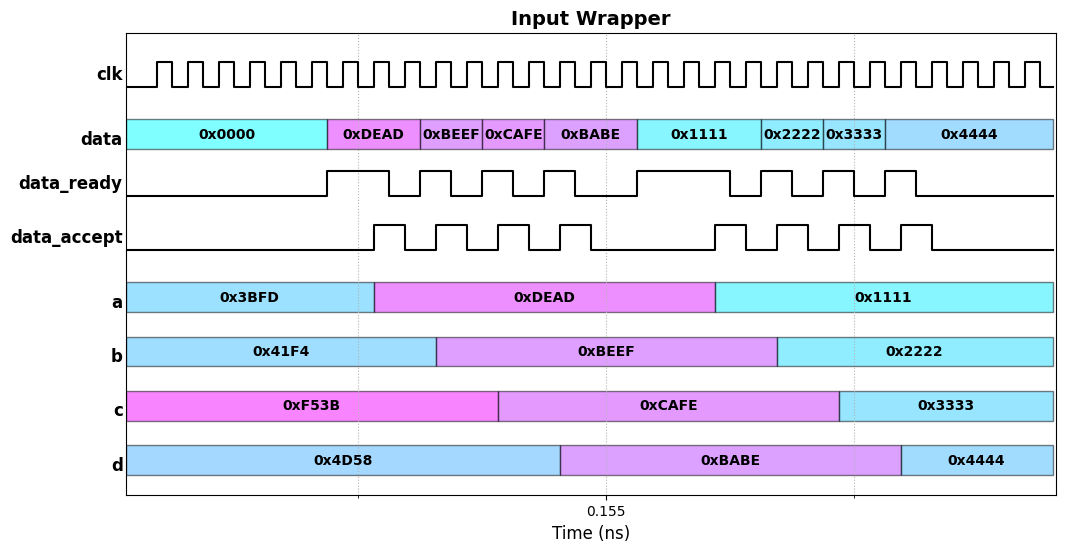

In [31]:
def get_signals(fname="../hdl/q2/logs/tb_in_wrapper.vcd"):
    vcd = vcdvcd.VCDVCD(fname)
    signal_tags = (
        ("TOP.clk", "clk"),
        ("TOP.data[15:0]", "data"),
        ("TOP.data_ready", "data_ready"),
        ("TOP.data_accept", "data_accept"),
        ("TOP.a[15:0]", "a"),
        ("TOP.b[15:0]", "b"),
        ("TOP.c[15:0]", "c"),
        ("TOP.d[15:0]", "d"),
    )
    
    endtime = max(vcd[name].endtime for name, _ in signal_tags)

    signals: List[Signal] = [
        Signal.load(vcd=vcd, signal_id=signal_id, title=title, endtime=endtime) 
        for signal_id, title in signal_tags]
    return signals

def plot_timing_diagram(signals):
    '''
    Normalize signals and space them out on one axis.
    '''
    fig, ax = plt.subplots(figsize=(12, 6))
    spacing = 2.2

    clk_signal = next(sig for sig in signals if sig.title == "clk")

    offsets = {}
    for i, signal in enumerate(signals):
        y_offset = -i * spacing
        offsets[signal.title] = y_offset
        endtime = signal.endtime
        xscale = signal.xscale
        label = signal.title

        to_print = ['data', 'a', 'b', 'c', 'd']
        if label in to_print:
            x = np.array(signal.x) * xscale * 1e9
            y_offset_rect = y_offset - 0.3

            prev_val = -1000
            for j in range(len(x) - 1):
                t_start, t_end = x[j], x[j + 1]
                val     = signal.y[j]

                if val is not None and val != prev_val:
                    print(val)
                    # Normalize color to range [0,255]
                    color = plt.cm.cool(val / 0xFFFF)
                    ax.add_patch(plt.Rectangle(
                        (t_start, y_offset_rect),
                        t_end - t_start,
                        1.2,
                        facecolor=color,
                        edgecolor='black',
                        alpha=0.5
                    ))
                    # Label the rectangle with the decimal value
                    ax.text(
                        (t_start + t_end) / 2,
                        y_offset_rect + 0.6,
                        f"0x{int(val):04X}",
                        ha="center",
                        va="center",
                        fontsize=10,
                        color="black",
                        weight="bold"
                    )
                    prev_val = val
            ax.text(-1e-3, y_offset_rect + 0.4, label,
                    ha="right", va="center", fontsize=12, weight="bold")
            continue

        # --- Default digital waveform plotting ---
        x = np.array(signal.x) * xscale * 1e9
        y_range = (max(signal.y) - min(signal.y))
        y = np.zeros_like(signal.y) if y_range == 0 else np.array(signal.y) / y_range

        ax.step(x, y_offset + y, where="post", color="black", lw=1.5)
        ax.hlines(y_offset, 0, endtime * xscale, color="0.8", lw=0.5, linestyle="--")
        ax.text(-1e-3, y_offset + 0.5, label, ha="right", va="center",
                fontsize=12, weight="bold")

    # Formatting
    ax.set_ylim(-spacing*(len(signals)-1) - spacing/2, spacing)
    ax.set_xlabel("Time (ns)", fontsize=12)
    ax.set_yticks([])
    ax.set_title("Input Wrapper", fontsize=14, weight="bold")

    # Gridlines
    ax.xaxis.set_major_locator(plt.MultipleLocator(0.16, offset=-0.005))
    ax.xaxis.set_minor_locator(plt.MultipleLocator(0.08, offset=-0.005))
    ax.grid(axis="x", which="minor", linestyle=":", color="0.7")
    ax.grid(axis="x", which="major", linestyle=":", color="0.7")

    return fig, [ax]

signals = get_signals()
fig, axes = plot_timing_diagram(list(signals))
axes[0].set_xlim(0.0, 0.30)
fig.savefig("../report/assets/q2_in_wrapper_wave.pdf", bbox_inches="tight")
plt.show()

In [1]:
def get_signals(fname="../hdl/q2/logs/tb_out_wrapper.vcd"):
    vcd = vcdvcd.VCDVCD(fname)
    signal_tags = (
        ("TOP.clk_i", "clk"),
        ("TOP.imc_ready_i", "imc_ready_i"),
        ("TOP.avail_o", "available_o"),
        ("TOP.start_transmit_i", "start_transmit_i"),
        ("TOP.request_o", "request_o"),
        ("TOP.grant_i", "grant_i"),
        ("TOP.ready_o", "ready_o"),
        ("TOP.data_o[15:0]", "data_o"),
        ("TOP.accepted_i", "accepted_i")
    )
    
    endtime = max(vcd[name].endtime for name, _ in signal_tags)

    signals: List[Signal] = [
        Signal.load(vcd=vcd, signal_id=signal_id, title=title, endtime=endtime) 
        for signal_id, title in signal_tags]
    return signals

def plot_timing_diagram(signals):
    '''
    Normalize signals and space them out on one axis.
    '''
    fig, ax = plt.subplots(figsize=(12, 6))
    spacing = 2.2

    clk_signal = next(sig for sig in signals if sig.title == "clk")

    offsets = {}
    for i, signal in enumerate(signals):
        y_offset = -i * spacing
        offsets[signal.title] = y_offset
        endtime = signal.endtime
        xscale = signal.xscale
        label = signal.title

        to_print = ['data_o', 'a', 'b', 'c', 'd']
        if label in to_print:
            x = np.array(signal.x) * xscale * 1e9
            y_offset_rect = y_offset - 0.3

            prev_val = -1000
            for j in range(len(x) - 1):
                t_start, t_end = x[j], x[j + 1]
                val     = signal.y[j]

                if val is not None and val != prev_val:
                    print(val)
                    # Normalize color to range [0,255]
                    color = plt.cm.cool(val / 0xFFFF)
                    ax.add_patch(plt.Rectangle(
                        (t_start, y_offset_rect),
                        t_end - t_start,
                        1.2,
                        facecolor=color,
                        edgecolor='black',
                        alpha=0.5
                    ))
                    # Label the rectangle with the decimal value
                    if val == 0.0:
                        text = "0xZZZZ"
                    else:
                        text = f"0x{int(val):04X}"
                    ax.text(
                        (t_start + t_end) / 2,
                        y_offset_rect + 0.6,
                        text,
                        ha="center",
                        va="center",
                        fontsize=10,
                        color="black",
                        weight="bold"
                    )
                    prev_val = val
            ax.text(-1e-3, y_offset_rect + 0.4, label,
                    ha="right", va="center", fontsize=12, weight="bold")
            continue

        # --- Default digital waveform plotting ---
        x = np.array(signal.x) * xscale * 1e9
        y_range = (max(signal.y) - min(signal.y))
        y = np.zeros_like(signal.y) if y_range == 0 else np.array(signal.y) / y_range

        ax.step(x, y_offset + y, where="post", color="black", lw=1.5)
        ax.hlines(y_offset, 0, endtime * xscale, color="0.8", lw=0.5, linestyle="--")
        ax.text(-1e-3, y_offset + 0.5, label, ha="right", va="center",
                fontsize=12, weight="bold")

    # Formatting
    ax.set_ylim(-spacing*(len(signals)-1) - spacing/2, spacing)
    ax.set_xlabel("Time (ns)", fontsize=12)
    ax.set_yticks([])
    ax.set_title("Output Wrapper", fontsize=14, weight="bold")

    # Gridlines
    ax.xaxis.set_major_locator(plt.MultipleLocator(0.16, offset=-0.005))
    ax.xaxis.set_minor_locator(plt.MultipleLocator(0.08, offset=-0.005))
    ax.grid(axis="x", which="minor", linestyle=":", color="0.7")
    ax.grid(axis="x", which="major", linestyle=":", color="0.7")

    return fig, [ax]

signals = get_signals()
fig, axes = plot_timing_diagram(list(signals))
axes[0].set_xlim(0.0, 0.25)
fig.savefig("../report/assets/q3_wave.pdf", bbox_inches="tight")
plt.show()

NameError: name 'vcdvcd' is not defined

1.2346056164365087e+18
0.0
136.0
119.0
102.0
85.0
68.0
51.0
34.0
17.0
0.0


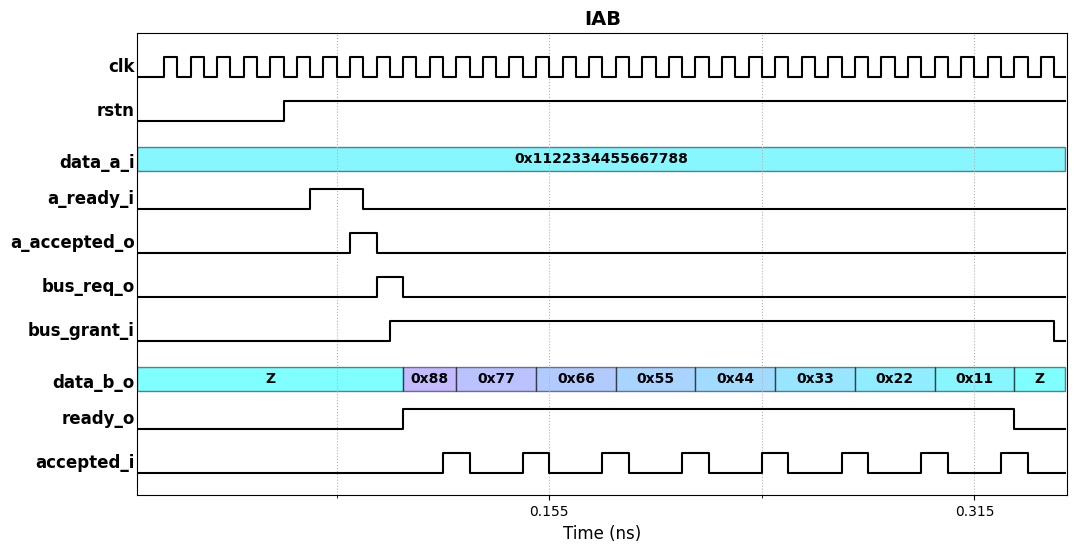

In [17]:
def get_signals(fname="../hdl/q3/logs/tb_iab.vcd"):
    vcd = vcdvcd.VCDVCD(fname)
    signal_tags = (
        ("TOP.clk_i", "clk"),
        ("TOP.rstn_i", "rstn"),
        ("TOP.data_a_i[63:0]", "data_a_i"),
        ("TOP.a_ready_i", "a_ready_i"),
        ("TOP.accepted_a_o", "a_accepted_o"),
        ("TOP.bus_req_o", "bus_req_o"),
        ("TOP.bus_grant_i", "bus_grant_i"),
        ("TOP.data_b_o[7:0]", "data_b_o"),
        ("TOP.ready_o", "ready_o"),
        ("TOP.accepted_i", "accepted_i")
    )
    
    endtime = max(vcd[name].endtime for name, _ in signal_tags)

    signals: List[Signal] = [
        Signal.load(vcd=vcd, signal_id=signal_id, title=title, endtime=endtime) 
        for signal_id, title in signal_tags]
    return signals

def plot_timing_diagram(signals):
    '''
    Normalize signals and space them out on one axis.
    '''
    fig, ax = plt.subplots(figsize=(12, 6))
    spacing = 2.2

    clk_signal = next(sig for sig in signals if sig.title == "clk")

    offsets = {}
    for i, signal in enumerate(signals):
        y_offset = -i * spacing
        offsets[signal.title] = y_offset
        endtime = signal.endtime
        xscale = signal.xscale
        label = signal.title

        to_print = ['data_b_o', 'data_a_i']
        if label in to_print:
            x = np.array(signal.x) * xscale * 1e9
            y_offset_rect = y_offset - 0.3

            prev_val = -1000
            for j in range(len(x) - 1):
                t_start, t_end = x[j], x[j + 1]
                val     = signal.y[j]

                if val is not None and val != prev_val:
                    print(val)
                    # Normalize color to range [0,255]
                    color = plt.cm.cool(val / (0xFFFFFFFFFFFFFFFF if label == "data_a_i" else 0xFF))
                    ax.add_patch(plt.Rectangle(
                        (t_start, y_offset_rect),
                        t_end - t_start,
                        1.2,
                        facecolor=color,
                        edgecolor='black',
                        alpha=0.5
                    ))
                    # Label the rectangle with the decimal value
                    if label == "data_a_i":
                        text = "0x1122334455667788"
                    else:
                        text = f"0x{int(val):02X}" 
                    if val == 0.0:
                        text = "Z"
                    ax.text(
                        (t_start + t_end) / 2,
                        y_offset_rect + 0.6,
                        text,
                        ha="center",
                        va="center",
                        fontsize=10,
                        color="black",
                        weight="bold"
                    )
                    prev_val = val
            ax.text(-1e-3, y_offset_rect + 0.4, label,
                    ha="right", va="center", fontsize=12, weight="bold")
            continue

        # --- Default digital waveform plotting ---
        x = np.array(signal.x) * xscale * 1e9
        y_range = (max(signal.y) - min(signal.y))
        y = np.zeros_like(signal.y) if y_range == 0 else np.array(signal.y) / y_range

        ax.step(x, y_offset + y, where="post", color="black", lw=1.5)
        ax.hlines(y_offset, 0, endtime * xscale, color="0.8", lw=0.5, linestyle="--")
        ax.text(-1e-3, y_offset + 0.5, label, ha="right", va="center",
                fontsize=12, weight="bold")

    # Formatting
    ax.set_ylim(-spacing*(len(signals)-1) - spacing/2, spacing)
    ax.set_xlabel("Time (ns)", fontsize=12)
    ax.set_yticks([])
    ax.set_title("IAB", fontsize=14, weight="bold")

    # Gridlines
    ax.xaxis.set_major_locator(plt.MultipleLocator(0.16, offset=-0.005))
    ax.xaxis.set_minor_locator(plt.MultipleLocator(0.08, offset=-0.005))
    ax.grid(axis="x", which="minor", linestyle=":", color="0.7")
    ax.grid(axis="x", which="major", linestyle=":", color="0.7")

    return fig, [ax]

signals = get_signals()
fig, axes = plot_timing_diagram(list(signals))
axes[0].set_xlim(0.0, 0.35)
fig.savefig("../report/assets/q3_wave.pdf", bbox_inches="tight")
plt.show()